<a href="https://colab.research.google.com/github/SaketMunda/mnist-digit-recognition/blob/master/recognise_handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Digit Recognition

Deep Learning model for Handwritten Digit Recognition using TensorFlow and Neural Network Techniques

## 1. Problem Definition ⛑

Recognise handwritten digit, from a dataset which contains B&W images of each digit written on 28x28 pixel box.

## 2. Data 

The data we're using is officially provided by [The MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)

The digits have been sized-normalized and centered in a fixed-sized image.

The data is quite preprocessed and well-formatted.

## 3. Evaluation

Test Error Rate(%) should be lower than 1.0

## 4. Features

Some information about the data,
* We're dealing with images(unstructured data) so it's probably best we use deep learning/transfer learning technique to solve this problem.
* There are around a 60,000 examples of training set. 
* There are around a 10,000 examples of test set.

## Get Workspace ready !

* Import Tensorflow
* Import Tensorflow hub
* Check if GPU is running or not

In [1]:
# import tensorflow
import tensorflow as tf
print(tf.__version__)

2.9.2


In [2]:
# import tensorflow hub
import tensorflow_hub as hub
print(hub.__version__)

0.12.0


In [3]:
# check for GPU availibility
print("GPU", "available (YES !!!!!!)"if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YES !!!!!!)


## Getting our data ready

I've manually downloaded the data from MNIST database, and uploaded into my Google drive.

### Load the data

We have the data in gzip and IDX format so have to un-gzip the files and then read the IDX file using numpy. 

In [7]:
import gzip
import numpy as np

In [8]:
# Create a function to read the mnist data
def read_mnist(images_path: str, labels_path:str):
  with gzip.open(labels_path,'rb') as labelsFile:
    labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)
  with gzip.open(images_path, 'rb') as imagesFile:
    length = len(labels)
    # Load flat 28x28 px images (784px), and convert them to 28x28 px
    features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                   .reshape(length, 784) \
                   .reshape(length, 28, 28, 1)
  return features, labels

In [9]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('drive/MyDrive/Data Science/MNIST Handwritten Digits/data/train-images-idx3-ubyte.gz', 
                                                'drive/MyDrive/Data Science/MNIST Handwritten Digits/data/train-labels-idx1-ubyte.gz')

test['features'], test['labels'] = read_mnist('drive/MyDrive/Data Science/MNIST Handwritten Digits/data/t10k-images-idx3-ubyte.gz',
                                              'drive/MyDrive/Data Science/MNIST Handwritten Digits/data/t10k-labels-idx1-ubyte.gz')

### Explore the data

Before going further and jumping directly to any step, exploring the data will help us to decide what are the things we need to do with our data,
* Find outliers
* If we need a preprocessing phase to uniform
* Check the number of images and labels
* Visualize some numbers

In [31]:
# Number of training samples
train["features"].shape[0], train["labels"].shape[0]

(60000, 60000)

In [30]:
# Number of test samples
test["features"].shape[0], test["labels"].shape[0]

(10000, 10000)

In [24]:
# Splitting into separate train and test variables
X_train = train["features"]
y_train = train["labels"]

X_test = test["features"]
y_test = test["labels"]

In [29]:
# let's see some attributes of the data
X_train[0].ndim, X_train[0].shape

(3, (28, 28, 1))

In [34]:
# observing the data
# X_train[0]
# commented this to avoid scorlling

### Visualize the data

It didn't really say anything. We must plot it using matplotlib since the values that are in the form of array is the value of grayscale between the value of Black and White.

In [33]:
import matplotlib.pyplot as plt

In [39]:
def display_image(index):
  image = X_train[index].squeeze()
  plt.title(f"Index {index} Label: {y_train[index]}")
  plt.imshow(image, cmap=plt.cm.gray_r)

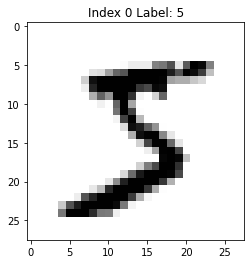

In [40]:
display_image(0)

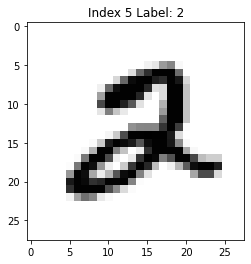

In [41]:
display_image(5)

Let's identify how many labels we have in our training set and their corresponding images.

In [47]:
import pandas as pd
train_label_counts = np.unique(y_train, return_counts=True)
train_label_df = pd.DataFrame({"Label": train_label_counts[0], "Count":train_label_counts[1]})
train_label_df

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


It says, Digit `1` has 6742 samples, `2` has 5958, `3` has 6131 samples and so on... available in training dataset.

Also by observing the data it looks like that it's already converted into numbers and it's ready to fit in into the model.


### Split the data into 3 set (Training, Validation and Test)

But as the rule suggests, we must divide the samples into 3 sets, (Training, Validation and Test set).

Since we already have the test set available, so we only need to divide the validation test which we split it from training samples.

* Training Samples : (48K)
* Validation Samples : (12K)
* Test Samples : (10K)

In [50]:
# importing train test split library from scikit-learn
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=17)

In [51]:
# see the number of splitted data
X_train.shape[0], X_valid.shape[0]

(48000, 12000)

and now if we compare the lables in each set, after splitting

In [52]:
np.unique(y_train, return_counts=True), np.unique(y_valid, return_counts=True)

((array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([4719, 5380, 4754, 4956, 4686, 4301, 4734, 5047, 4620, 4803])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([1204, 1362, 1204, 1175, 1156, 1120, 1184, 1218, 1231, 1146])))

### Data into Batches

If we want to train 10K+ samples in one go.. they all might not fit into memory.

So that's why we do about 32(this is the batch size) samples at a time. But here I'll consider 128 samples of one batch.

**But if all the samples fit into memory then we don't need to convert them into batches.**

[Resource](https://www.tensorflow.org/guide/data#reading_input_data)



In [58]:
# Define the batch size, 128 is a good start
BATCH_SIZE = 128

def create_data_batches(X, y=None, batch_size= BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of X and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input
  """

  # If the data is test dataset, we probabily don't have labels
  if test_data:
    print("Creating batches for test data....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) 
    data_batch = data.batch(batch_size)
    return data_batch
  # If the data is validation set, we do have labels but we don't shuffle it
  elif valid_data:
    print("Create batches for valid data....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.batch(batch_size)
    return data_batch
  # If the data is training set, we are shuffling the data
  else:
    print("Create batches for training data...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    # Shuffing the samples
    data = data.shuffle(buffer_size=len(X))
    # create data batches
    data_batch = data.batch(batch_size)
    return data_batch

In [59]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data=True)

Create batches for training data...
Create batches for valid data....


In [60]:
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None,), dtype=tf.uint8, name=None)),
 (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None,), dtype=tf.uint8, name=None)))

YEAH !!!!!!!

That's what we wanted. We turned them into tensors and created batches.

## Modelling

Before we build a model, there are few things we need to define:
* Input shape to our model.
* Output shape
* Choose the right estimator/model to train.

In [ ]:
# INPUT SHAPE
INPUT_SHAPE = []

# Output Shape
OUTPUT_SHAPE = []

# URL
MODEL_URL = ""